# Определение стоимости автомобилей

## Подготовка данных

Откроем файл с данными и изучим их, для этого подключим библиотеку `pandas` помимо неё подключим еще остальные библиотеки, которые нам пригодятся. Для того чтобы прочитать данные из датасета воспользуемся методом `read_csv`, для получения общей информации о датасете воспользуемся методом `info`. Но для начала установим недостающие библиотеки для использования моделей с градиентным бустингом:

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
import catboost

In [4]:
try:
    data = pd.read_csv('/datasets/autos.csv', index_col=False)
except:
    data = pd.read_csv('autos.csv', index_col=False)
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Как видно по данным, есть столбцы, в которых есть пропущенные значения:
- `VehicleType` — тип автомобильного кузова;
- `Gearbox` — тип коробки передач;
- `Model` — модель автомобиля;
- `FuelType` — тип топлива;
- `Repaired` — была машина в ремонте или нет.

Далее проанализируем значения в этих столбцам и заполним пропуски, в остальных столбцах пропусков в данных нет. Где-то половина столбцов имеет тип данных **object**, далее детальнее смотрим данные в этих в столбцах, но для начала приведем в корректный вид названия столбцов согласно стандарту Python. Напишем функцию для переименования столбцов и воспользуемся ей.

In [6]:
def rename_columns(columns): #функция для переименования столбцов
    '''
    Функция приводит название столбцов в датасете в формат shake case по стандарту Python,
    на вход функция принимает текущие названия столбцов в датасете в виде списка
    '''
    columns_rename = []
    new_name_column = ""
    for column in columns:
        for index_symbol in range(0, len(column), 1):
            if index_symbol == 0 and column[index_symbol].istitle(): #метод istitle проверяет является ли символ заглавным
                new_name_column += column[index_symbol].lower()
            elif index_symbol > 0 and column[index_symbol].istitle():
                new_name_column += '_' + column[index_symbol].lower()
            else:
                new_name_column += column[index_symbol]
        columns_rename.append(new_name_column)
        new_name_column = ""
    return columns_rename

In [7]:
data.columns = rename_columns(data.columns)
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Стобцы переименовались корректно, можно переходить к обработке пропусков.

Как мы заметили при просмотре данных, у нас в нескольких столбцах есть пропуски, стоить заметить, что все столбцы в которых есть пропуски в данных имеют тип данных **object**. Насчем с первого столбца где мы заметили пропуски `vehicle_type` — *тип автомобильного кузова*, построим гистограмму по данному столбцу, чтобы посмотреть какие в нем есть значения с помощью библиотеки `seaborn`:

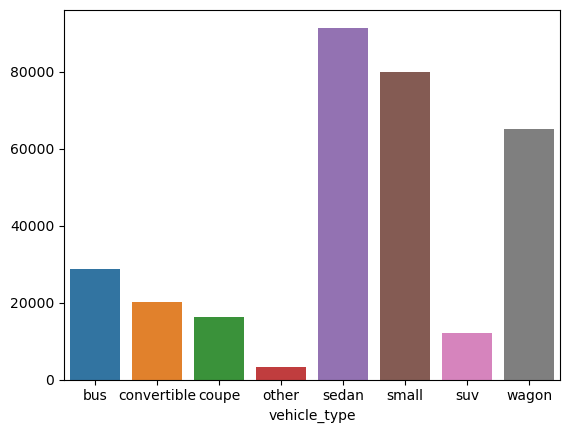

In [8]:
sns.barplot(x=data.groupby(by='vehicle_type')['vehicle_type'].count().index, 
            y=data.groupby(by='vehicle_type')['vehicle_type'].count().values
           )
pass

По графику видно, что у нас больше всего автомобилем с типом кузова **sedan**, меньше всего с типом кузова **other**. Можно заполнить пропущенные значение в данном столбце, значениями **other**, но у нас тогда получится по данному значению перевес и модель машинного обучения может тогда не верно обучиться. Данные в столбце не числовые и завязаться на корреляции в других столбцах тоже не получится, такая же ситуация с заполнением пропусков средним или медианым значением. Заполним пропуски в данном столбце значением *unknown*, укажем, что для этих машин тип автомобильного кузова неизвестен:

In [9]:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown')

Перейдем к следующему столбцу `model` — *модель автомобиля*, по сравнению со столбцем тип автомобильного кузова, который имеет не так много видов, в столбце с моделью автомабиля посмотрим сначала сколько уникальных значений в этом столбце, так названий модель автомобилей достаточно много:

In [10]:
print('Количество уникальных моделей автомобиля', data['model'].nunique())

Количество уникальных моделей автомобиля 250


У нас 250 уникальных моделей автомобилей в нашем датасете, такое количество аккаруатно на график не поместишь. Как и с предыдущим столбцом у этого столбца тип данных **object**, заполним пропуски в данном столбце значением *unknown*, укажем, что для этих автомобилей модель неизвестна:

In [11]:
data['model'] = data['model'].fillna('unknown')

Посмотрим данные в столбце `gearbox` — *тип коробки передач*, здесь сразу можно построить график по значениям, так как тут не будет такого количества уникальных значений, как в столбце с модель автомобиля:

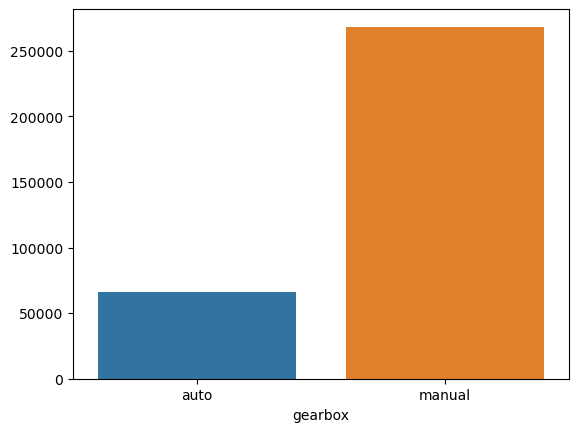

In [12]:
sns.barplot(x=data.groupby(by='gearbox')['gearbox'].count().index, 
            y=data.groupby(by='gearbox')['gearbox'].count().values
           )
pass

В данном столбце всего два значения **auto** и **manual**, что означает автоматическая и ручная коробка передач соответственно. Мы можем по каждом модели автомобиля зайти на сайт производителя и определить какой тип коробки передачи у указанной модели, но у нас слишком много данных для таких действий. Заполним пропуски в данном столбце значением *unknown*:

In [13]:
data['gearbox'] = data['gearbox'].fillna('unknown')

Перейдем к следующему столбцу `fuel_type` — *тип топлива*, с помощью графика посмотрим какие значения есть в столбце:

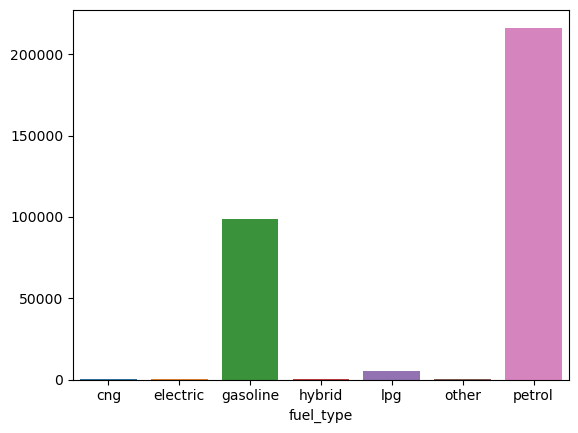

In [14]:
sns.barplot(x=data.groupby(by='fuel_type')['fuel_type'].count().index, 
            y=data.groupby(by='fuel_type')['fuel_type'].count().values
           )
pass

Как видно по графику в датасете в основном представлены автомобили, которые ездят либо на газу, либо на бензине, причем на бензин в два раза больше, чем на газу. Так как у нас графике несколько различных значений по типу топлива, заполним пропуски в данном столбце значением *unknown*, как и ранее для других столбцов:

In [15]:
data['fuel_type'] = data['fuel_type'].fillna('unknown')

Построиим графикам по значениям из столбца `repaired` — *была машина в ремонте или нет*:

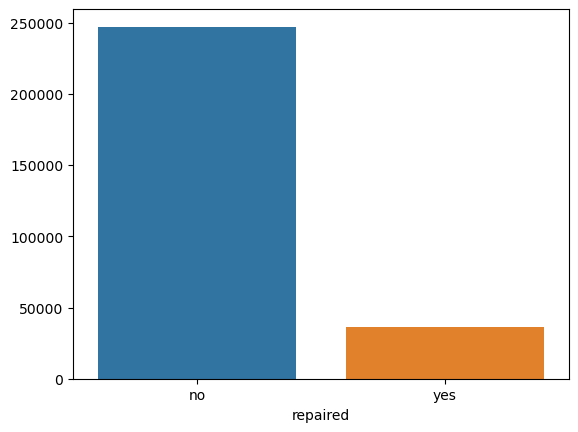

In [16]:
sns.barplot(x=data.groupby(by='repaired')['repaired'].count().index, 
            y=data.groupby(by='repaired')['repaired'].count().values
           )
pass

У данного столбца всего два значение — **yes** или **no**. Большая часть представленных автомобилей в датасете в ремонте не была. Логично предположить, что пропущенные значения в данном столбце для некоторых автомобилей подразумеают то, что автомобиль скорей всего в ремонте не был, и в датасете как мы видим по графику, большая часть предоставленных автомобилей в ремонте не была, заполним пропущенные значение в данном столбце значением **no**:

In [17]:
data['repaired'] = data['repaired'].fillna('no')

Проверим остались ли у нас пропуски в столбцах:

In [18]:
pd.set_option('display.max_rows', None)
print(data.isna().sum())
pd.set_option('display.max_rows', 10)

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64


Как видно с пропусками мы разобрались, посмотрим теперь есть ли явные дубликаты в данных:

In [19]:
data.duplicated().sum()

5

Есть **5** явных дубликатов, удалим их из датасета:

In [20]:
data = data.drop_duplicates()

In [21]:
data.duplicated().sum()

0

Явных дубликатов не осталось. Проверим теперь наличие неявных дубликатов в столбцах, где есть строковые значения, чтобы проверить, что у нас в датасете нет, например, одинаковых названий брендов или моделей автомобиля записанных в разных регистрах. Проверять будем в следующих столбцах:

- `vehicle_type` — тип автомобильного кузова;
- `gearbox` — тип коробки передач;
- `model` — модель автомобиля;
- `fuel_type` — тип топлива;
- `brand` — марка автомобиля.

Проверим у каждого из этих столбцов уникальные значения:

In [22]:
for column_name in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']:
    print('\n' + column_name, sorted(data[column_name].unique()))


vehicle_type ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'unknown', 'wagon']

gearbox ['auto', 'manual', 'unknown']

model ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klas

Как видно по данным неявных дубликатов в указанным столбцах нет. Проверять на неявные дубликаты в столбах где указаны какие-либо числа или даты не имеет смысла, так как естественно есть автомобили, которые зарегистировали в одинаковые даты, либо у таких автомобилей может быть одинаковая мощность. Логично проверять такие данные на различные аномалии, например, не указано ли, что автомобиль зарегистрирован в году, когда автомобили ещё не выпускали или же наоборот они зарегистрированы в году, которые ещё не наступил, или же для автомобиля указали нулевую мощность, что в принципе невозможно. Проверим данные на наличие аномалий в следующих столбцах:

- `registration_year` — год регистрации автомобиля;
- `power` — мощность (л. с.);
- `kilometer` — пробег (км);
- `registration_month` — месяц регистрации автомобиля.

Так как у нас много столбцов в которых необходимо будет проверять данные, напишем функцию, которая будет показывать нам данные из указанного столбца, затем посмотрим сколько регистировалось автомобилей в различные года:

In [23]:
def show_count_all_data_bycolumn(dataset, name_column):
    '''
    Функция показывает все данные из указаного столбца, сгруппированные по количеству
    '''
    pd.set_option('display.max_rows', None)
    display(dataset.groupby(by=name_column)[name_column].count())
    pd.set_option('display.max_rows', 10)

In [24]:
show_count_all_data_bycolumn(data, 'registration_year')

registration_year
1000       37
1001        1
1039        1
1111        3
1200        1
1234        4
1253        1
1255        1
1300        2
1400        1
1500        5
1600        2
1602        1
1688        1
1800        5
1910      101
1915        1
1919        1
1920        1
1923        2
1925        1
1927        1
1928        2
1929        7
1930        3
1931        1
1932        3
1933        3
1934        3
1935        4
1936        3
1937       11
1938        8
1940        2
1941        2
1942        3
1943        4
1944        2
1945        4
1946        1
1947        2
1948        3
1949        1
1950       18
1951       12
1952        9
1953       14
1954       11
1955       15
1956       27
1957       13
1958       25
1959       32
1960      188
1961       41
1962       46
1963       57
1964       64
1965       82
1966      113
1967       99
1968      108
1969      118
1970      333
1971      167
1972      213
1973      173
1974      169
1975      143
1976      175
19

Как видно по данным, есть автомобили, которые были зарегистрированы раньше 1910 года, и даже 1800 года, когда автомобили даже ещё не изобрели. Также есть автомобили, которые зарегистрировали в те года, которые ещё не наступили, например, 2066 год и выше, даже есть автомобили, которые зарегистрировали в 9999 году. Как видно по данным, в таких года зарегистрированы не очень много автомобилей, в основном не больше 10, есть конечно исключения, где указано, что были зарегистрировано больше 10 автомобилей, но их все равно не так много. С учетом выше перечисленного оставим в датасете, только те автомобили, которые были зарегистрированы с **1910** по **2019** год, тогда наши данные будут больше соотвествовать реальности:

In [25]:
data = data[(data['registration_year'] > 1909) & (data['registration_year'] < 2020)]

Проверим ещё год регистрации автомобиля с годом в дате скачивания анкеты в столбце `date_crawled`, в данных не должно быть автомобиля с годом регистрации больше, чем указано в дате скачивания анкеты:

In [26]:
pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S').dt.year.unique()

array([2016], dtype=int64)

Год скачивания каждой анкеты **2016**, уберем дополнительно из датасета автомобили, которые были зарегистрированы позже **2016** года:

In [27]:
data = data[data['registration_year'] < 2017]

In [28]:
show_count_all_data_bycolumn(data, 'registration_year')

registration_year
1910      101
1915        1
1919        1
1920        1
1923        2
1925        1
1927        1
1928        2
1929        7
1930        3
1931        1
1932        3
1933        3
1934        3
1935        4
1936        3
1937       11
1938        8
1940        2
1941        2
1942        3
1943        4
1944        2
1945        4
1946        1
1947        2
1948        3
1949        1
1950       18
1951       12
1952        9
1953       14
1954       11
1955       15
1956       27
1957       13
1958       25
1959       32
1960      188
1961       41
1962       46
1963       57
1964       64
1965       82
1966      113
1967       99
1968      108
1969      118
1970      333
1971      167
1972      213
1973      173
1974      169
1975      143
1976      175
1977      173
1978      285
1979      283
1980      588
1981      263
1982      316
1983      430
1984      399
1985      756
1986      538
1987      667
1988      942
1989     1318
1990     2806
1991     2762
19

Данные по году регистрации автомобиля поправили, проверь теперь данные в столбце `power` — *мощность (л. с.)*, проверим нет ли у нас автомобилей со слишком маленькой мощностью. Посмотрим какая указана мощность у автомобилей в датасете:

In [29]:
show_count_all_data_bycolumn(data, 'power')

power
0        36453
1           31
2           10
3            8
4           30
5          103
6           11
7           11
8            7
9            5
10          13
11          28
12          20
13           6
14          19
15          19
16           7
17           7
18          51
19          13
20          22
21           5
22           5
23          44
24          29
25          15
26         286
27          37
28           5
29          34
30          33
31           9
32           5
33          52
34         180
35          10
36           7
37          49
38          20
39         135
40         310
41         432
42          48
43         108
44         377
45        2863
46          55
47          32
48          90
49          23
50        4444
51          90
52         302
53         200
54        5546
55        1974
56         261
57         131
58        3688
59         227
60       15169
61         970
62          93
63         390
64        1486
65        2109
66  

У **40098** автомобилей указана нулевая мощность, это чуть больше 10% от всех данных, удалить эти данные не получится, необходимо заменить на более корректные значения. В данных есть автомобили разных моделей и брендов, вряд ли по всем автомобилям определенной марки и бренда указали нулевую мощность, так как мы можем привязаться к модели и бренду, то по каждой модели и бренду можно посчитать медиану мощности и заменить этой медианой нулевые мощности у автомобилей:

In [30]:
#получаем медиану мощности по каждой модели и бренду
power_median_by_brand_and_model = data.groupby(by=['brand', 'model']).agg({'power': 'median'}).reset_index()
power_median_by_brand_and_model.columns = ['brand', 'model', 'power_median']
power_median_by_brand_and_model

,brand,model,power_median
0,alfa_romeo,145,103.0
1,alfa_romeo,147,120.0
2,alfa_romeo,156,150.0
3,alfa_romeo,159,160.0
4,alfa_romeo,other,150.0
...,...,...,...
332,volvo,v40,116.0
333,volvo,v50,136.0
334,volvo,v60,163.0
335,volvo,v70,163.0


Медианы получили, заменим теперь ими нулевые мощности:

In [31]:
for index_median in range(len(power_median_by_brand_and_model)):
    data.loc[(data['model'] == power_median_by_brand_and_model.loc[index_median, 'model']) & (
        data['brand'] == power_median_by_brand_and_model.loc[index_median, 'brand']) & (data['power'] == 0), 'power'] = \
    power_median_by_brand_and_model.loc[index_median, 'power_median']

Построим ещё раз данные в столбце `power` и посмотрим как изменились значения в этом столбце:

In [32]:
show_count_all_data_bycolumn(data, 'power')

power
0.0          128
1.0           31
2.0           10
3.0            8
4.0           30
5.0          103
6.0           11
7.0           11
8.0            7
9.0            5
10.0          13
11.0          28
12.0          20
13.0           6
14.0          19
15.0          19
16.0           7
17.0           7
18.0          51
19.0          13
20.0          22
21.0           5
22.0           5
23.0          44
24.0          29
25.0          15
26.0         447
27.0          37
28.0           5
29.0          34
30.0          40
31.0           9
32.0           5
33.0          52
34.0         302
35.0          10
36.0           7
37.0          49
38.0          20
39.0         135
40.0         327
41.0         432
42.0          61
43.0         108
44.0         377
45.0        2965
46.0          55
47.0          32
48.0          90
49.0          23
50.0        6124
51.0          90
52.0         374
53.0         215
54.0        5724
55.0        1974
56.0         335
57.0         131
58.0    

Остались автомобили с нулевой мощностью, но сейчас их **129**, а не **40** тысяч как в прошлый раз, оставшиеся автомобили с нулевой мощностью можно удалить. Также есть автомобили с очень большой мощностью, например **20000**, такие данные нам тоже не нужны. Есть автомобили с очень маленькой мощностью, так как указаны автомобили с годом регистрации от **1910**, то маленькая мощность у автомобиля вполне возможна. Удалим из датасета автомобили с нулевой мощностью, и автомобили у которых мощности больше **2000**, берем больше **2000**, потому что на текущий момент времени самая мощная легковая машина имеет такую мощность:

In [33]:
data = data[(data['power'] != 0) & (data['power'] < 2001)]

In [34]:
show_count_all_data_bycolumn(data, 'power')

power
1.0          31
2.0          10
3.0           8
4.0          30
5.0         103
6.0          11
7.0          11
8.0           7
9.0           5
10.0         13
11.0         28
12.0         20
13.0          6
14.0         19
15.0         19
16.0          7
17.0          7
18.0         51
19.0         13
20.0         22
21.0          5
22.0          5
23.0         44
24.0         29
25.0         15
26.0        447
27.0         37
28.0          5
29.0         34
30.0         40
31.0          9
32.0          5
33.0         52
34.0        302
35.0         10
36.0          7
37.0         49
38.0         20
39.0        135
40.0        327
41.0        432
42.0         61
43.0        108
44.0        377
45.0       2965
46.0         55
47.0         32
48.0         90
49.0         23
50.0       6124
51.0         90
52.0        374
53.0        215
54.0       5724
55.0       1974
56.0        335
57.0        131
58.0       4764
59.0        227
60.0      20080
61.0       1335
62.0         93
63

Проверим данные в поле `kilometer` — *пробег (км)*:

In [35]:
show_count_all_data_bycolumn(data, 'kilometer')

kilometer
5000        5889
10000       1130
20000       3801
30000       4312
40000       4815
50000       6056
60000       7280
70000       8355
80000       9743
90000      11189
100000     14399
125000     35029
150000    227533
Name: kilometer, dtype: int64

С пробегом у автомобилей все хорошо, нет нулевых и данные по пробегу очень похожи на реальные данные. Проверим теперь какие указаны месяцы в столбце `registration_month` — месяц регистрации автомобиля:

In [36]:
show_count_all_data_bycolumn(data, 'registration_month')

registration_month
0     33507
1     22454
2     20544
3     33179
4     28177
5     28119
6     30376
7     26287
8     21816
9     23071
10    25247
11    23371
12    23383
Name: registration_month, dtype: int64

Есть автомобили, которые зарегистрировали в нулевой месяц, можно было посчитать, что так указали первый месяц в году, однако в датасете есть автомобили, который зарегистрировали в двенацатый месяц, получается что в датасете автомобили регистрировали в **13** месяцев, хотя в году всего **12** месяцев. Заменить нулевой месяц на первый не получится, так как видно что в 1 и 2 месяцы падает регистрации автомобилей, а к весенним и летним месяцам она работает начинает расти, по этому заменим нулевой месяц на месяц по медиане:

In [37]:
data['registration_month'] = data['registration_month'].replace(0, data['registration_month'].median())

In [38]:
show_count_all_data_bycolumn(data, 'registration_month')

registration_month
1     22454
2     20544
3     33179
4     28177
5     28119
6     63883
7     26287
8     21816
9     23071
10    25247
11    23371
12    23383
Name: registration_month, dtype: int64

Нулевой месяц успешно убрали из датасете. Посмотрим теперь данные в столбце `price` — *цена*, проверим нет ли автомобилей с нулевой ценой:

In [39]:
show_count_all_data_bycolumn(data, 'price')

price
0        9971
1        1116
2          11
3           7
4           1
5          25
7           3
8           1
9           7
10         82
11          5
12          8
13          7
14          5
15         25
16          2
17          5
18          2
19          3
20         47
21          1
24          1
25         31
26          1
27          1
29          2
30         53
32          1
33          1
35         17
38          1
39          5
40         45
45         14
47          1
49         11
50        319
55         18
58          1
59          5
60         53
65         18
66          2
69          3
70         69
74          1
75         54
77          1
79          4
80        144
85         10
88          1
89          3
90         41
95         13
98          2
99        104
100      1013
101         4
105         3
108         1
110        35
111        15
112         1
115         4
117         4
119         4
120       237
121         1
122         3
123         3


**10** тысяч автомобилей в датасете указаны с нулевой ценой. Нулевую цену автомобили заменим на медиану цены по каждой модели и бренду, как это сделали ранее для столбца `power` — *мощность*:

In [40]:
#получаем медиану цены по каждой модели и бренду
price_median_by_brand_and_model = data.groupby(by=['brand', 'model']).agg({'price': 'median'}).reset_index()
price_median_by_brand_and_model.columns = ['brand', 'model', 'price_median']
price_median_by_brand_and_model

,brand,model,price_median
0,alfa_romeo,145,500.0
1,alfa_romeo,147,1950.0
2,alfa_romeo,156,1200.0
3,alfa_romeo,159,6400.0
4,alfa_romeo,other,5799.0
...,...,...,...
331,volvo,v40,999.0
332,volvo,v50,5500.0
333,volvo,v60,16490.0
334,volvo,v70,2750.0


Медианы получили, заменим теперь ими нулевые цены:

In [41]:
for index_median in range(len(price_median_by_brand_and_model)):
    data.loc[(data['model'] == price_median_by_brand_and_model.loc[index_median, 'model']) & (
        data['brand'] == price_median_by_brand_and_model.loc[index_median, 'brand']) & (data['price'] == 0), 'price'] = \
    price_median_by_brand_and_model.loc[index_median, 'price_median']

Построим ещё раз данные в столбце `price` и посмотрим как изменились значения в этом столбце:

In [42]:
show_count_all_data_bycolumn(data, 'price')

price
1.0        1116
2.0          11
3.0           7
4.0           1
5.0          25
7.0           3
8.0           1
9.0           7
10.0         82
11.0          5
12.0          8
13.0          7
14.0          5
15.0         25
16.0          2
17.0          5
18.0          2
19.0          3
20.0         47
21.0          1
24.0          1
25.0         31
26.0          1
27.0          1
29.0          2
30.0         53
32.0          1
33.0          1
35.0         17
38.0          1
39.0          5
40.0         45
45.0         14
47.0          1
49.0         11
50.0        319
55.0         18
58.0          1
59.0          5
60.0         53
65.0         18
66.0          2
69.0          3
70.0         69
74.0          1
75.0         54
77.0          1
79.0          4
80.0        144
85.0         10
88.0          1
89.0          3
90.0         41
95.0         13
98.0          2
99.0        104
100.0      1013
101.0         4
105.0         3
108.0         1
110.0        35
111.0        15
11

Автомобилей с нулевой ценой больше не остались. Данные во всех столбцах предобработали, можно переходить к обучению моделей:

## Обучение моделей

Прежде, чем разделить данные на выборки, уберем из датасета те столбцы, которые нам не пригодятся в обучении модели — это столбцы:
- `date_crawled` — *дата скачивания анкеты из базы*;
- `registration_month` — *месяц регистрации автомобиля*;
- `date_created` — *дата создания анкеты*;
- `postal_code` — *почтовый индекс владельца анкеты (пользователя)*;
- `number_of_pictures` — *количество фотографий автомобиля*;
- `last_seen` — *дата последней активности пользователя*.

Мы убрали признаки, которые не влияют на цену автомобиля, даты размещения анкеты и последней активности, почтовый индекс не относятся к характеристикам машины, поэтому эти столбцы можно убрать. Месяц регистрации тоже убираем, так как есть столбец с годом регистрации автомобиля, при покупке машины в основном смотрят на год регистрации. Количество фотографий автомобиля тоже не убираем, так как это не техническая характеристика, количество фото скорее влияет на то как быстро удаться продать автомобиля, в основном при покупке больше будут смотреть на технические характеристики автомобиля, в каком году её зарегистрировали, какой у неё пробег и т.д.

In [43]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 'postal_code', 'number_of_pictures', 'last_seen'], 
                 axis=1)
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480.0,unknown,1993,manual,98.0,golf,150000,petrol,volkswagen,no
1,18300.0,coupe,2011,manual,190.0,unknown,125000,gasoline,audi,yes
2,9800.0,suv,2004,auto,163.0,grand,125000,gasoline,jeep,no
3,1500.0,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600.0,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no


Столбцы удалились корректно, разделим теперь данные на три выборки — обучащая **60%**, валидационная **20%** и тестовая **20%**, для этого воспользуемся методом `train_test_split` из библиотеки `sklearn`:

In [44]:
data_train, data_valid = train_test_split(data, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_valid, test_size=0.5, random_state=12345)
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(203718, 10)
(67906, 10)
(67907, 10)


По размерности видно, что выборки разделились корректно, теперь выбирем из данных признаки и что необходимо предсказать. В задание указано, что нужно **построить модель, которая умеет определять рыночную стоимость автомобиля**, стоимость хранится в столбце `price` — это будет целевой признак, который нам необходимо будет предсказать, а все остальные столбцы вынесем в признаки по которым будем предсказывать целевой признак.

In [45]:
data_train_features = data_train.drop(['price'], axis=1)
data_train_target = data_train['price']

data_valid_features = data_valid.drop(['price'], axis=1)
data_valid_target = data_valid['price']

data_test_features = data_test.drop(['price'], axis=1)
data_test_target = data_test['price']

Так как у нас есть категориальные признаки, то необходимо их преобразовать в числовые, для этого воспользуемся техникой **порядкового кодирования**. Чтобы применить **порядковое кодирование** на наших данных, воспользуемся методом `OrdinalEncoder` из библиотеки `sklearn`. Сначала обучим `OrdinalEncoder` на обучающей выборке, затем преобразуем данные на валидационной и тестовой выборке. `OrdinalEncoder` будем применять на столбцах в которых содержатся категориальные признаки:

- `vehicle_type` — тип автомобильного кузова;
- `gearbox` — тип коробки передач;
- `model` — модель автомобиля;
- `fuel_type` — тип топлива;
- `brand` — марка автомобиля;
- `repaired` — была машина в ремонте или нет.

In [46]:
features_categorical = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)
ordinal_enc.fit(data_train_features[features_categorical])

#создаем отдельные выборки с кодированными данными
data_train_features_ord_enc = data_train_features.copy()
data_valid_features_ord_enc = data_valid_features.copy()
data_test_features_ord_enc = data_test_features.copy()

data_train_features_ord_enc[features_categorical] = ordinal_enc.transform(data_train_features[features_categorical])
data_valid_features_ord_enc[features_categorical] = ordinal_enc.transform(data_valid_features[features_categorical])
data_test_features_ord_enc[features_categorical] = ordinal_enc.transform(data_test_features[features_categorical])

Проверяем как преобразовались данные:

In [47]:
display(data_train_features_ord_enc.head())
display(data_valid_features_ord_enc.head())
display(data_test_features_ord_enc.head())

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
165450,0.0,2004,1.0,105.0,223.0,150000,2.0,38.0,0.0
200994,0.0,2008,1.0,175.0,193.0,150000,2.0,10.0,0.0
298023,7.0,2016,1.0,75.0,116.0,150000,6.0,38.0,0.0
272617,5.0,1998,1.0,75.0,78.0,150000,6.0,22.0,0.0
258271,4.0,2002,1.0,102.0,166.0,80000,6.0,15.0,0.0


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
78632,7.0,2016,1.0,60.0,116.0,150000,2.0,38.0,0.0
104262,8.0,1992,1.0,250.0,166.0,150000,6.0,1.0,0.0
173234,8.0,2005,0.0,218.0,15.0,150000,2.0,2.0,0.0
169589,7.0,1990,1.0,90.0,116.0,150000,7.0,38.0,0.0
302172,8.0,1998,1.0,102.0,11.0,150000,6.0,2.0,0.0


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
171650,4.0,1996,1.0,125.0,29.0,150000,6.0,1.0,0.0
323840,7.0,2005,2.0,98.0,116.0,125000,7.0,38.0,0.0
207286,4.0,1998,1.0,177.0,15.0,150000,6.0,2.0,1.0
205186,5.0,2001,2.0,61.0,106.0,150000,2.0,32.0,0.0
101878,8.0,2001,1.0,103.0,166.0,150000,6.0,9.0,1.0


Как видно по данным, есть количественные признаки с разным разбросом значений, например, столбцы `power` — *мощность* и `kilometer` — *пробег*, очевидно, что разброс значений у столбца с пробегом больше, в таком случае алгорим может решить, что признаки с большими значениями и разбросом важнее. Чтобы избежать этой ловушки, признаки масштабируются — приводятся к одному масштабу. Один из методов масштабирования — **стандартизации данных**, примением его на наших данных, для этого воспользуемся структурой *StandardScaler* из библиотеки `sklearn`.

In [48]:
scaler = StandardScaler()
columns_names = data_train_features_ord_enc.columns
scaler.fit(data_train_features_ord_enc[columns_names])

#создаем отдельные выборки с масштабированными данными
data_train_features_ord_enc_sca = data_train_features_ord_enc.copy()
data_valid_features_ord_enc_sca = data_valid_features_ord_enc.copy()
data_test_features_ord_enc_sca = data_test_features_ord_enc.copy()

data_train_features_ord_enc_sca[columns_names] = scaler.transform(data_train_features_ord_enc[columns_names])
data_valid_features_ord_enc_sca[columns_names] = scaler.transform(data_valid_features_ord_enc[columns_names])
data_test_features_ord_enc_sca[columns_names] = scaler.transform(data_test_features_ord_enc[columns_names])

Проверим как данные отмасштабировались:

In [49]:
display(data_train_features_ord_enc_sca.head())
display(data_valid_features_ord_enc_sca.head())
display(data_test_features_ord_enc_sca.head())

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
165450,-1.949703,0.213065,0.288532,-0.231540,1.469420,0.577379,-1.537220,1.289406,-0.337339
200994,-1.949703,0.775797,0.288532,0.910074,1.061467,0.577379,-1.537220,-0.812705,-0.337339
298023,0.982544,1.901262,0.288532,-0.720803,0.014388,0.577379,0.585725,1.289406,-0.337339
272617,0.144759,-0.631033,0.288532,-0.720803,-0.502352,0.577379,0.585725,0.088200,-0.337339
258271,-0.274133,-0.068301,0.288532,-0.280466,0.694310,-1.272405,0.585725,-0.437328,-0.337339


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
78632,0.982544,1.901262,0.288532,-0.965435,0.014388,0.577379,-1.537220,1.289406,-0.337339
104262,1.401436,-1.475131,0.288532,2.133232,0.694310,0.577379,0.585725,-1.488384,-0.337339
173234,1.401436,0.353748,-1.830402,1.611351,-1.359052,0.577379,-1.537220,-1.413308,-0.337339
169589,0.982544,-1.756497,0.288532,-0.476172,0.014388,0.577379,1.116462,1.289406,-0.337339
302172,1.401436,-0.631033,0.288532,-0.280466,-1.413446,0.577379,0.585725,-1.413308,-0.337339


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
171650,-0.274133,-0.912399,0.288532,0.094635,-1.168675,0.577379,0.585725,-1.488384,-0.337339
323840,0.982544,0.353748,2.407467,-0.345702,0.014388,-0.083258,1.116462,1.289406,-0.337339
207286,-0.274133,-0.631033,0.288532,0.942691,-1.359052,0.577379,0.585725,-1.413308,2.964380
205186,0.144759,-0.208984,2.407467,-0.949126,-0.121596,0.577379,-1.537220,0.838954,-0.337339
101878,1.401436,-0.208984,0.288532,-0.264158,0.694310,0.577379,0.585725,-0.887781,2.964380


Данные успешно отмасштабировались во всех выборках, можно переходить к обучениям моделей машинного обучения. Для решения нашей задачи возьмем следующие модели **Линейная регрессия**, **Дерево решений для регрессии**, **Случайный лес для регрессии**, и модели, которые используют градиентный бустинг **LightGBM**, **CatBoost**. Для проверки моделей будем использовать метрику *RMSE*, по заданию **значение метрики RMSE должно быть меньше 2500**. Также измерим время обучения модели и время предсказания модели. Начнем с модели **Линейной регрессии**, так как модель линейная, для преобразования категориальных признаков в числовые необходимо использовать технику **Прямого кодирования**, чтобы применить **прямое кодирование** на наших данных, воспользуемся методом `get_dummies` из библиотеки `pandas`.

In [50]:
# прямое кодирование (для линейных моделей)
data_train_features_ohe = pd.get_dummies(data_train_features, drop_first=True)
data_valid_features_ohe = pd.get_dummies(data_valid_features, drop_first=True)
data_test_features_ohe = pd.get_dummies(data_test_features, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(data_train_features_ohe.columns) & set(data_valid_features_ohe.columns) & set(
    data_test_features_ohe.columns)

# Оставим в каждой выборке только общие признаки
data_train_features_ohe = data_train_features_ohe[list(common_columns)]
data_valid_features_ohe = data_valid_features_ohe[list(common_columns)]
data_test_features_ohe = data_test_features_ohe[list(common_columns)]

Проверяем как преобразовались данные:

In [51]:
display(data_train_features_ohe.head())
display(data_valid_features_ohe.head())
display(data_test_features_ohe.head())

,vehicle_type_small,model_cx_reihe,model_logan,model_q5,brand_sonstige_autos,model_6_reihe,model_signum,model_croma,model_justy,model_lanos,...,vehicle_type_wagon,model_x_trail,brand_rover,brand_volvo,model_panda,model_e_klasse,model_getz,model_omega,vehicle_type_convertible,model_fox
165450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
298023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272617,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
258271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,vehicle_type_small,model_cx_reihe,model_logan,model_q5,brand_sonstige_autos,model_6_reihe,model_signum,model_croma,model_justy,model_lanos,...,vehicle_type_wagon,model_x_trail,brand_rover,brand_volvo,model_panda,model_e_klasse,model_getz,model_omega,vehicle_type_convertible,model_fox
78632,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104262,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
173234,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
169589,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
302172,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


,vehicle_type_small,model_cx_reihe,model_logan,model_q5,brand_sonstige_autos,model_6_reihe,model_signum,model_croma,model_justy,model_lanos,...,vehicle_type_wagon,model_x_trail,brand_rover,brand_volvo,model_panda,model_e_klasse,model_getz,model_omega,vehicle_type_convertible,model_fox
171650,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
207286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205186,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101878,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Так как используем линейную модель, необходимо привести признаки к одному масштабу, иначе модель может решить, что признаки с большими значениями и разбросом важнее:

In [52]:
scaler = StandardScaler()
columns_names = data_train_features_ohe.columns
scaler.fit(data_train_features_ohe[columns_names])

#создаем отдельные выборки с масштабированными данными
data_train_features_ohe_sca = data_train_features_ohe.copy()
data_valid_features_ohe_sca = data_valid_features_ohe.copy()
data_test_features_ohe_sca = data_test_features_ohe.copy()

data_train_features_ohe_sca[columns_names] = scaler.transform(data_train_features_ohe_sca[columns_names])
data_valid_features_ohe_sca[columns_names] = scaler.transform(data_valid_features_ohe_sca[columns_names])
data_test_features_ohe_sca[columns_names] = scaler.transform(data_test_features_ohe_sca[columns_names])

Проверим как данные отмасштабировались:

In [53]:
display(data_train_features_ohe_sca.head())
display(data_valid_features_ohe_sca.head())
display(data_test_features_ohe_sca.head())

,vehicle_type_small,model_cx_reihe,model_logan,model_q5,brand_sonstige_autos,model_6_reihe,model_signum,model_croma,model_justy,model_lanos,...,vehicle_type_wagon,model_x_trail,brand_rover,brand_volvo,model_panda,model_e_klasse,model_getz,model_omega,vehicle_type_convertible,model_fox
165450,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,-0.487044,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
200994,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,-0.487044,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
298023,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,-0.487044,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
272617,1.804047,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,-0.487044,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
258271,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,-0.487044,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831


,vehicle_type_small,model_cx_reihe,model_logan,model_q5,brand_sonstige_autos,model_6_reihe,model_signum,model_croma,model_justy,model_lanos,...,vehicle_type_wagon,model_x_trail,brand_rover,brand_volvo,model_panda,model_e_klasse,model_getz,model_omega,vehicle_type_convertible,model_fox
78632,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,-0.487044,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
104262,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,2.053204,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
173234,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,2.053204,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
169589,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,-0.487044,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
302172,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,2.053204,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831


,vehicle_type_small,model_cx_reihe,model_logan,model_q5,brand_sonstige_autos,model_6_reihe,model_signum,model_croma,model_justy,model_lanos,...,vehicle_type_wagon,model_x_trail,brand_rover,brand_volvo,model_panda,model_e_klasse,model_getz,model_omega,vehicle_type_convertible,model_fox
171650,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,-0.487044,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
323840,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,-0.487044,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
207286,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,-0.487044,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
205186,1.804047,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,-0.487044,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831
101878,-0.554309,-0.014014,-0.030794,-0.017448,-0.097977,-0.060991,-0.038403,-0.010393,-0.02031,-0.015028,...,2.053204,-0.024176,-0.037033,-0.097337,-0.04441,-0.141756,-0.033693,-0.063805,-0.249851,-0.045831


Данные успешно отмасштабировались во всех выборках, можно переходить к обучению модели **Линейной регрессии**.

In [54]:
model_linear_reg = LinearRegression()

In [55]:
%%time
model_linear_reg.fit(data_train_features_ohe_sca, data_train_target)

Wall time: 4.68 s


LinearRegression()

In [56]:
%%time
model_linear_reg_predictions = model_linear_reg.predict(data_valid_features_ohe_sca)

Wall time: 212 ms


In [57]:
print('RMSE Линейной регрессии', mean_squared_error(data_valid_target, model_linear_reg_predictions, squared=False))

RMSE Линейной регрессии 2787.9353653278085


Значение метрики *RMSE* у модели **Линейной регрессии** равно **2787**, слишком большая для нашего задания, зато модель быстро предсказывает данные на валидационной выборке. Переберем гиперпараметры у моделей **Дерево решений для регрессии**, **Случайный лес для регрессии** с помощью `GridSearchCV` может получиться подобрать модель с более подходящим значением по метрике *RMSE*.

In [58]:
model_tree = DecisionTreeRegressor(random_state=12345)
grid_tree = GridSearchCV(model_tree, param_grid={'max_depth': [1, 30]}, scoring='neg_mean_squared_error')
grid_tree.fit(data_train_features_ord_enc_sca, data_train_target)
print('Best params', grid_tree.best_params_)
print('Best score RMSE', abs(grid_tree.best_score_) ** 0.5)

Best params {'max_depth': 30}
Best score RMSE 2105.5941343587147


С помощью `GridSearchCV` мы узнали, что на обучающей выборке лучшая модель **Дерево решений для регрессии** с глубиной деревьев равное **30**, проверим данную модель на валидационной выборке и измерим за какое время модель обучается и предсказывает данные:

In [59]:
%%time
best_model_tree = DecisionTreeRegressor(random_state=12345, max_depth=30)
best_model_tree.fit(data_train_features_ord_enc_sca, data_train_target)

Wall time: 627 ms


DecisionTreeRegressor(max_depth=30, random_state=12345)

In [60]:
%%time
best_model_tree_predictions = best_model_tree.predict(data_valid_features_ord_enc_sca)

Wall time: 44.1 ms


In [61]:
print('RMSE Дерево решений для регрессии', 
      mean_squared_error(data_valid_target, best_model_tree_predictions, squared=False))

RMSE Дерево решений для регрессии 2039.0357719748624


Модель **Дерево решений для регрессии** можно сказать, что обучалась быстрее в **7** раз модели **Линейной регрессии**, также она почти в **5** раз быстрее предсказывает данные на валидационной выборке. Также, значение метрики *RMSE* у данной модели значетильно ниже, чем у модели **Линейной регрессии** и составляет **2039**. Сделаем теперь перебор гиперпараметров через `GridSearchCV` для модели **Случайный лес для регрессии**:

In [62]:
model_forest = RandomForestRegressor(random_state=12345)
params = {
    'max_depth': [1, 5, 10, 15, 20, 25, 30],
    'n_estimators': [1, 10, 20, 30, 40, 50]
}
grid_forest = GridSearchCV(model_forest, param_grid=params, scoring='neg_mean_squared_error')
grid_forest.fit(data_train_features_ord_enc_sca, data_train_target)
print('Best params', grid_forest.best_params_)
print('Best score RMSE', abs(grid_tree.best_score_) ** 0.5)

Best params {'max_depth': 20, 'n_estimators': 50}
Best score RMSE 2105.5941343587147


Лучшая модель **Случайный лес для регрессии** с параметрами количества деревьев равное **50** и с глубиной каждого дерева равное **20**, проверим данную модель на валидационной выборке и измерим за какое время модель обучается и предсказывает данные:

In [63]:
%%time
best_model_forest = RandomForestRegressor(random_state=12345, max_depth=20, n_estimators=50)
best_model_forest.fit(data_train_features_ord_enc_sca, data_train_target)

Wall time: 18.4 s


RandomForestRegressor(max_depth=20, n_estimators=50, random_state=12345)

In [64]:
%%time
best_model_forest_predictions = best_model_forest.predict(data_valid_features_ord_enc_sca)

Wall time: 772 ms


In [65]:
print('RMSE Случайный лес для регрессии', 
      mean_squared_error(data_valid_target, best_model_forest_predictions, squared=False))

RMSE Случайный лес для регрессии 1655.8936494624554


Модель **Случайный лес для регрессии** показывает лучше значение по *RMSE* равное **1655** на валидационной выборке, однако данная модель обучается в **30** раз дольше модели **Дерево решений для регрессии** и **4** раза дольше модели **Линейной регрессии**. Время прелсказания у модели **Случайный лес для регрессии** больше в **17** раз, чем у модели **Дерево решений для регрессии** и в почти **4** раза больше, чем у модели **Линейной регрессии**. Перейдем теперь к моделям, использующие градиетный бустинг, обучим модель **LightGBM**:

In [66]:
params = {
    'max_depth': [1, 5, 10, 15, 20, 25, 30],
    'learning_rate': [0.1, 0.2, 0.3]
}
model_lgbm = lgb.LGBMRegressor(random_state=12345)
grid_lgbm = GridSearchCV(model_lgbm, param_grid=params, scoring='neg_mean_squared_error')
grid_lgbm.fit(data_train_features_ord_enc_sca, data_train_target)
print('Best params', grid_lgbm.best_params_)
print('Best score RMSE', abs(grid_tree.best_score_) ** 0.5)

Best params {'learning_rate': 0.3, 'max_depth': 20}
Best score RMSE 2105.5941343587147


С помощью `GridSearchCV` мы выяснили, что наилучшие параметры для модели **LightGBM**  — глубина дерева равное **20**, скорость обучения равная **0.3**, проверим данную модель на валидационной выборке:

In [67]:
%%time
best_model_lgbm = lgb.LGBMRegressor(random_state=12345, max_depth=15, learning_rate=0.3)
best_model_lgbm.fit(data_train_features_ord_enc_sca, data_train_target)

Wall time: 407 ms


LGBMRegressor(learning_rate=0.3, max_depth=15, random_state=12345)

In [68]:
%%time
best_model_lgbm_predictions = best_model_lgbm.predict(data_valid_features_ord_enc_sca)

Wall time: 61.5 ms


In [69]:
print('RMSE LightGBM', mean_squared_error(data_valid_target, best_model_lgbm_predictions, squared=False))

RMSE LightGBM 1680.6469303128254


Модель **LightGBM** показвает пока что наилучший результат в совокупности по метрике *RMSE* равна **1680** и скорости и времени предсказания. Обучим ещё одну модель использующую градиентный бустинг **CatBoost**. Для перебора гиперпараметров для поиска наилучшей модели, будем использовать встроенный метод `grid_search`. Для проверки качества модели **CatBoost** по умолчанию использует метрику *RMSE*. Для **CatBoost** будем использовать данные, на которых не использовали **порядковое кодирование** на категориальных признаках, так как **CatBoost** сам может преобразовать категориальные признаки.

In [70]:
params = {
    'max_depth': [1, 5, 10, 15],
    'learning_rate': [0.1, 0.2, 0.3],
    'iterations': [100]
}
model_catboost = catboost.CatBoostRegressor(random_state=12345, silent=True, cat_features=features_categorical)
model_catboost.grid_search(params, X=data_train_features, y=data_train_target)


bestTest = 2440.640768
bestIteration = 99

0:	loss: 2440.6407685	best: 2440.6407685 (0)	total: 1.88s	remaining: 20.7s

bestTest = 2290.217415
bestIteration = 99

1:	loss: 2290.2174150	best: 2290.2174150 (1)	total: 3.47s	remaining: 17.3s

bestTest = 2257.831882
bestIteration = 99

2:	loss: 2257.8318823	best: 2257.8318823 (2)	total: 5.13s	remaining: 15.4s

bestTest = 1897.823823
bestIteration = 99

3:	loss: 1897.8238235	best: 1897.8238235 (3)	total: 9.53s	remaining: 19.1s

bestTest = 1826.551741
bestIteration = 99

4:	loss: 1826.5517408	best: 1826.5517408 (4)	total: 13.8s	remaining: 19.4s

bestTest = 1793.201235
bestIteration = 99

5:	loss: 1793.2012349	best: 1793.2012349 (5)	total: 18.2s	remaining: 18.2s

bestTest = 1758.903848
bestIteration = 99

6:	loss: 1758.9038479	best: 1758.9038479 (6)	total: 26s	remaining: 18.5s

bestTest = 1706.166998
bestIteration = 99

7:	loss: 1706.1669977	best: 1706.1669977 (7)	total: 32.7s	remaining: 16.3s

bestTest = 1695.82551
bestIteration = 98

8:	loss

{'params': {'depth': 15, 'iterations': 100, 'learning_rate': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

Наилучшие параметры для модели **CatBoost**  — глубина дерева равное **15**, скорость обучения равная **0.2**, проверим данную модель на валидационной выборке:

In [71]:
%%time
best_model_catboost = catboost.CatBoostRegressor(random_state=12345, silent=True, cat_features=features_categorical, 
                                                max_depth=15, learning_rate=0.2, iterations=100)
best_model_catboost.fit(data_train_features, data_train_target)

Wall time: 59.9 s


In [72]:
%%time
best_model_catboost_predictions = best_model_catboost.predict(data_valid_features)

Wall time: 173 ms


In [73]:
print('RMSE CatBoost', mean_squared_error(data_valid_target, best_model_catboost_predictions, squared=False))

RMSE CatBoost 1630.72914365466


По сравнению с остальными моделями, у модели **CatBoost** самое низкое значение по метрике *RMSE* на валидационной выборке — **1630**. Однако модель **CatBoost** обучается и предсказывает дольше, чем модель **LightGBM**, которая тоже использует градиентный бустинг.

Мы обучили несколько моделей машинного обучения, проверили их на валидационной выборке, проведем теперь анализ моделей на тестовой выборке.

## Анализ моделей

Соберем все данные по моделям, которые получились по итогу обучения моделей и проверки их на валидационной выборке:
- **Линейная регрессия** — RMSE: **2787**, время обучения: **4.68** секунды, время предсказания: **212** миллисекунд;
- **Дерево решений для регрессии** — RMSE: **2039**, время обучения: **627** миллисекунд, время предсказания: **44.1** миллисекунды;
- **Случайный лес для регрессии** — RMSE: **1655**, время обучения: **18.4** секунд, время предсказания: **772** миллисекунды;
- **LightGBM** — RMSE: **1680**, время обучения: **407** миллисекунд, время предсказания: **61.5** миллисекунды;
- **CatBoost** — RMSE: **1630**, время обучения: **59.9** миллисекунд, время предсказания: **173** миллисекунды.

Модель **Линейная регрессия** на тестовой выборке проверять не будем, у неё значение по метрике *RMSE* равно **2787**, а по заданию значение метрики *RMSE* должно быть меньше **2500**. У всех остальных моделей значение метрики *RMSE* ниже **2500**, однако у всех разное время обучения и предсказания. Самое большое время обучения и время предсказания у моделей **CatBoost** и **Случайный лес для регрессии**, так как у этих моделей высокий показатель по времени обучения и предсказания их тоже не имеет смысла проверять на тестовой выборке. У нас остались модели **Дерево решений для регрессии** и **LightGBM**, эти модели достаточно быстро обучаются и предсказывают, однако у модели **Дерево решений для регрессии** значение метрики *RMSE* больше, чем у модели **LightGBM**, также можно сказать, что модель **LightGBM** обучилась в **1.5** раза быстрее, чем модель **Дерево решений для регрессии**, у модели **Дерево решений для регрессии** есть преимущество перед моделью **LightGBM** в виде времени предсказания, однако это преимущество теряет свой смысл из-за того значение метрики *RMSE* выше, чем у модели **LightGBM**. С учетом изложенного выше имеет смысл проверять на тестовой выборке, только модель **LightGBM**.

## Тестирование лучшей модели

In [74]:
%%time
best_model_lgbm_predictions_by_test = best_model_lgbm.predict(data_test_features_ord_enc_sca)

Wall time: 71.2 ms


In [75]:
print('RMSE LightGBM на тестовой выборке', 
      mean_squared_error(data_test_target, best_model_lgbm_predictions_by_test, squared=False))

RMSE LightGBM на тестовой выборке 1697.349049032979


Время предсказания у модели **LightGBM** чуть увеличилось по сравнению с временем на валидационной выборке — **71.2** миллисекунды, значение по метрике *RMSE* также немного увеличилось — **1697**, что говорит о том, что мы сделали правильный выбор в пользу этой модели. Проверим теперь модель на адекватность с помощью `DummyRegressor`, которая будет предсказывать только среднее значение.

In [76]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(data_train_features_ord_enc_sca, data_train_target)
prediction_dummy_reg = dummy_regr.predict(data_test_features_ord_enc_sca)
print('RMSE DummyRegressor на тестовой выборке:', 
      mean_squared_error(data_test_target, prediction_dummy_reg, squared=False))

RMSE DummyRegressor на тестовой выборке: 4504.840493434617


Метрика *RMSE* у модели, которая предсказывает только среднее значение больше примерно в **2.5** раза, чем у модели **LightGBM**, которую мы выбрали для проверки на тестовой выборке, что говорит о том, что модель делает адекватные предсказания.

### Общий вывод

В рамках данной задачи нам необходимо было построить модель, которая может **предсказать рыночную стоимость автомобиля** по предоставленным данным. Предоставленные данные были обратоны от пропусков и дубликатов, перед обучением моделей из данных убрали лишние признаки, которые не нужны для обучения моделей. По заданию, у модели значение метрике *RMSE* должно быть ниже **2500**, также необходимо было учитывать время обучения и время предсказания моделей. Были обучены следующие модели  — **Линейная регрессия**, **Дерево решений для регрессии**, **Случайный лес для регрессии**, **LightGBM**, **CatBoost**. Модель **Линейная регрессия** на валидационной выборке показала самый высокое значение по метрике *RMSE*, выше **2500**, у остальных моделей значение по метрике *RMSE* было ниже **2500**, однако некоторые из них слишком долго обучались. На основании проведенного анализа для проверки на тестовой выборке была выбрана модель **LightGBM**, скорость обучения у данной модели составляет **407** миллисекунд, время предсказания на тестовой выборке **71.2** миллисекунды, также данная модель была проверена на адекватность.

На основании выше изложенного, для предсказания рыночной стоимости автомобиля необходимо использовать модель **LightGBM**, так как данная модель продемонстрировали необходимоые показатели по метрике *RMSE* — **1697**, а также по времени обучения **407** миллисекунд и времени предсказания **71.2** миллисекунды.